# Extreme Learning Machine Based Prognostics of Battery Life
**Reference:** R. Razavi-Far, S. Chakrabarti, M. Saif, E. Zio and V. Palade, "Extreme Learning Machine Based Prognostics of Battery Life," in International Journal on Artificial Intelligence Tools, Vol. 27, No. 08 (2018)

DOI: 10.1142/S0218213018500367

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install torchinfo torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 18.7 MB/s 


## Import dataset from Google Drive
Alternatively, upload the NASA.npy file to Colab instance.

In [ ]:
# import packages
import shutil
from google.colab import drive

# Mount drive
drive.mount('/content/drive', force_remount=True)

# Copy to location
dest = '/content/'                                      # this is in the colab VM
drive_src = '/content/drive/MyDrive/datasets/NASA/'     # location from GDrive (folder)
src = drive_src + "NASA.npy"                            # Specify file name
print(f"Copying {src} to {dest}")                       
shutil.copy(src,dest)                                   # Copy to dest

Mounted at /content/drive
Copying /content/drive/MyDrive/datasets/NASA/NASA.npy to /content/


'/content/NASA.npy'

## Importing Packages

In [ ]:
import numpy as np
import random
import math
#import os
#import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
#import torch.nn.functional as F
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Setting up device-agnostic code

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Data Processing
Load the pre-processed data. Make sure that NASA.npy is in the same directory as this notebook, or that it has been uploaded to the Colab instance (if using Google Colab).

In [ ]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
Battery = np.load('NASA.npy', allow_pickle=True)
Battery = Battery.item()

Plot the data to confirm dataset has been loaded successfully.

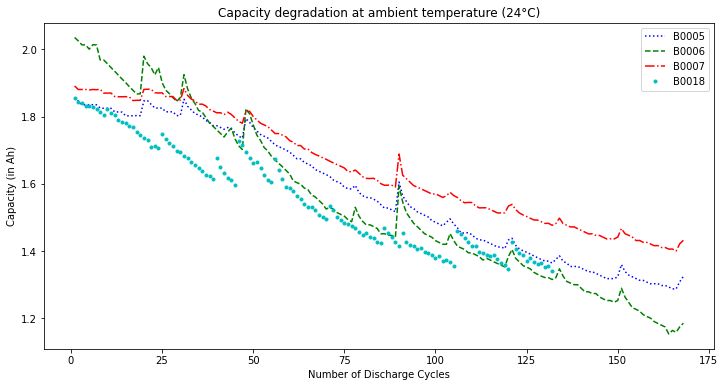

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 6))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Number of Discharge Cycles', ylabel='Capacity (in Ah)', title='Capacity degradation at ambient temperature (24°C)')
plt.legend()

## Functions for building the data sequences

In [ ]:
def split_seq(sequence, window_size=8, end=1):
  '''
  Splits an input sequence by a defined window size up to a defined portion of the sequence.
  Outputs array X with window_size steps and array y with the next step.

  Keyword arguments:
  ------------------
  sequence -- the  sequence to be split
  window_size -- sequence length of X (default: 8)
  end -- define what percent of the sequence to include (default: 1)
  '''
  # define empty variable
  X, y = [], []


  for i in range(len(sequence)):

    # compute end index
    end_i = i + window_size

    # check if end of the sequence is reached; break if end is reached
    if (end_i) > ( round(len(sequence)*end) - 1):
      break

    seq_x, seq_y = sequence[i:end_i], sequence[end_i] 
    X.append(seq_x)
    y.append(seq_y)

  return np.array(X), np.array(y)

Split the data into training and testing sets.

In [ ]:
def split_train_test(Battery_list, 
                     Battery, 
                     leave_out,
                     window_size=16, 
                     end=1,
                     train_split=1,
                     test_split=0.4):
  
  Train_list = Battery_list.copy()

  for entry in leave_out:
    Train_list.pop(Train_list.index(entry))

  sequences = {}

  for item in Battery_list:
    Cycle, Capacity = Battery[item]
    X_cap, y_cap = split_seq(Capacity, window_size, end)
    sequences[item] = X_cap, y_cap

  X_train, y_train = [], []
  X_test, y_test = [], []

  test_sequence = {}
  test_labels = {}

  for item in Train_list:
    # Access items from sequences dictionary
    X_cap, y_cap = sequences[item]

    # Get number of data points
    data_points = len(X_cap)
    data_points_test = len(Capacity)

    # Compute train-test split index
    train_split_idx = round(train_split * data_points)
    
    # Split the data to training and test set
    X_train.append(X_cap[:(train_split_idx)])
    y_train.append(y_cap[:(train_split_idx)])

  for item in leave_out:
    # For one step ahead
    X_cap, y_cap = sequences[item]
    data_points = len(X_cap)
    test_split_idx = round(test_split * data_points)

    X_test.append(X_cap[(test_split_idx):])
    y_test.append(y_cap[(test_split_idx):])

    # For Iterative multi step ahead
    Cycle, Capacity = Battery[item]
    data_points_test = len(Capacity)
    test_split_idx = round(test_split * data_points_test)

    # Create dictionary for test
    test_sequence[item] = Capacity[:(test_split_idx)], Cycle[:(test_split_idx)]
    test_labels[item] = Capacity[(test_split_idx):], Cycle[(test_split_idx):]

  # Concatenate lists
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  X_test = np.concatenate(X_test, axis=0)
  y_test = np.concatenate(y_test, axis=0)

  # Reshape y
  y_train = y_train.reshape(-1,1)
  y_test = y_test.reshape(-1,1)

  # Convert to tensors
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
  X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
  y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

  return X_train, y_train, X_test, y_test, test_sequence, test_labels

In [ ]:
# Rated capacity and threshold end-of-life capacity
Rated_Capacity = {}
Rated_Capacity['B0005'] = 2.0143
Rated_Capacity['B0006'] = 1.9857
Rated_Capacity['B0007'] = 2.1571
Rated_Capacity['B0018'] = 2.0143
threshold = 0.7       # 70% of total capacity (30% degraded)

# Window size is the number of cycles used to predict next cycle
window_size = 16

# Train split defines what percent of the total cycles of each battery
# dataset will be used to train
train_split = 1 

'''Test_split defines what percent of the total cycles of the battery left out
for testing will be used as input to predict future cycles
Ex. for test_split of 0.6, first 60% cycles will be used as input to predict
the remaining 40%'''
test_split = 0.6

X_train, y_train = {}, {}
X_test, y_test = {}, {}
test_sequence, test_labels = {}, {}

for leave_out in Battery_list:
  X_train[leave_out], y_train[leave_out], \
  X_test[leave_out], y_test[leave_out], \
  test_sequence[leave_out], test_labels[leave_out] = split_train_test(Battery_list=Battery_list, 
                                                      Battery = Battery, 
                                                      leave_out = [leave_out],
                                                      window_size = window_size, 
                                                      end = 1,
                                                      train_split = train_split,
                                                      test_split = test_split)

  print(f"{X_train[leave_out].shape}, {y_train[leave_out].shape},\
  {X_test[leave_out].shape}, {y_test[leave_out].shape}")


torch.Size([420, 16]), torch.Size([420, 1]),  torch.Size([61, 16]), torch.Size([61, 1])
torch.Size([420, 16]), torch.Size([420, 1]),  torch.Size([61, 16]), torch.Size([61, 1])
torch.Size([420, 16]), torch.Size([420, 1]),  torch.Size([61, 16]), torch.Size([61, 1])
torch.Size([456, 16]), torch.Size([456, 1]),  torch.Size([46, 16]), torch.Size([46, 1])


Save test tensors to file

In [ ]:
torch.save((X_test, y_test, test_sequence, test_labels),'test_tensors_ELM_NASA.pt')

## ELM Model declaration

In [ ]:
class ELM(nn.Module):
  def __init__(self,
               input_size:int,
               hidden_size:int,
               output_size:int,
               activation,
               X_train: torch.tensor,
               y_train: torch.tensor):
    
    super().__init__()

    #self.activation = nn.Sigmoid()
    #self.activation = nn.ReLU()
    self.activation = activation
    #self.activation = nn.LeakyReLU()
    #self.activation = nn.Tanh()

    self.input_weights= torch.normal(mean=0,std=1,size=(input_size, hidden_size), device=X_train.device)
    self.biases = torch.normal(mean=0,std=1,size=(1,hidden_size), device=X_train.device).squeeze(0)

    self.hidden_nodes = self.activation(torch.matmul(X_train, self.input_weights) + self.biases)

    self.output_weights = torch.matmul(torch.linalg.pinv(self.hidden_nodes), y_train)

  def forward(self, x):
    out = self.activation( torch.matmul(x, self.input_weights) + self.biases)
    out = torch.matmul(out, self.output_weights)
    return out

## Instantiate the Model
Note: ELM does not not require a training loop. Output weight $\hat{\beta}$ is computed by multiplying the Moore-Penrose Pseudoinverse of the hidden nodes $H$ with the train labels matrix $T$:

$ \hat{\beta} = H^{\dagger}T$

In [ ]:
import os
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [ ]:
# setup seed
seed = 3
setup_seed(seed)

# specify activation function
activation = nn.Sigmoid()
hidden_dim = 1024

model = {}

for leave_out in Battery_list:
  model[leave_out] = ELM(input_size=window_size, hidden_size=hidden_dim,
                      output_size=1,
                      activation=activation, 
                      X_train = X_train[leave_out],
                      y_train = y_train[leave_out]).to(device)

  torch.save(model[leave_out],f'ELM_NASA_{leave_out}.pt')

Make directory, move checkpoints, and zip

In [ ]:
!mkdir checkpoints
!mv ELM_NASA_B0005.pt checkpoints/ELM_NASA_B0005.pt
!mv ELM_NASA_B0006.pt checkpoints/ELM_NASA_B0006.pt
!mv ELM_NASA_B0007.pt checkpoints/ELM_NASA_B0007.pt
!mv ELM_NASA_B0018.pt checkpoints/ELM_NASA_B0018.pt
!zip -r checkpoints_ELM_NASA.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/ELM_NASA_B0007.pt (deflated 11%)
  adding: checkpoints/ELM_NASA_B0018.pt (deflated 11%)
  adding: checkpoints/ELM_NASA_B0005.pt (deflated 11%)
  adding: checkpoints/ELM_NASA_B0006.pt (deflated 11%)


## Test inference

Accuracy and error are defined by :

$ error = \dfrac{|y_{pred} - y_{test}|}{y_{test}} $

$ accuracy = 1 - error $

In [ ]:
'''
def accuracy(y_test: torch.tensor, y_pred: torch.tensor):
  error = torch.abs(y_pred-y_test)/y_test
  acc = 1 - error
  return float(acc)
'''

def accuracy(y_test: torch.tensor, y_pred: torch.tensor):
  error = torch.abs(y_pred - y_test)/y_test
  acc = torch.ones_like(error) - error
  acc = torch.sum(acc)/len(y_pred)
  return float(acc)

### One-Step Ahead Prediction
Test on test data set

Performance on Test Data B0005
Accuracy: 99.46795%	MAE: 0.00724	RMSE: 0.00010
RUL True: 11		RUL Pred: 12	RUL Error: -1
----------------------------------------------------------------
Performance on Test Data B0006
Accuracy: 98.59212%	MAE: 0.01763	RMSE: 0.00047
RUL True: 3		RUL Pred: 5	RUL Error: -2
----------------------------------------------------------------
Performance on Test Data B0007
Accuracy: 99.69819%	MAE: 0.00445	RMSE: 0.00006
RUL True: 16		RUL Pred: 12	RUL Error: 4
----------------------------------------------------------------
Performance on Test Data B0018
Accuracy: 98.98803%	MAE: 0.01426	RMSE: 0.00059
RUL True: 8		RUL Pred: 9	RUL Error: -1
----------------------------------------------------------------


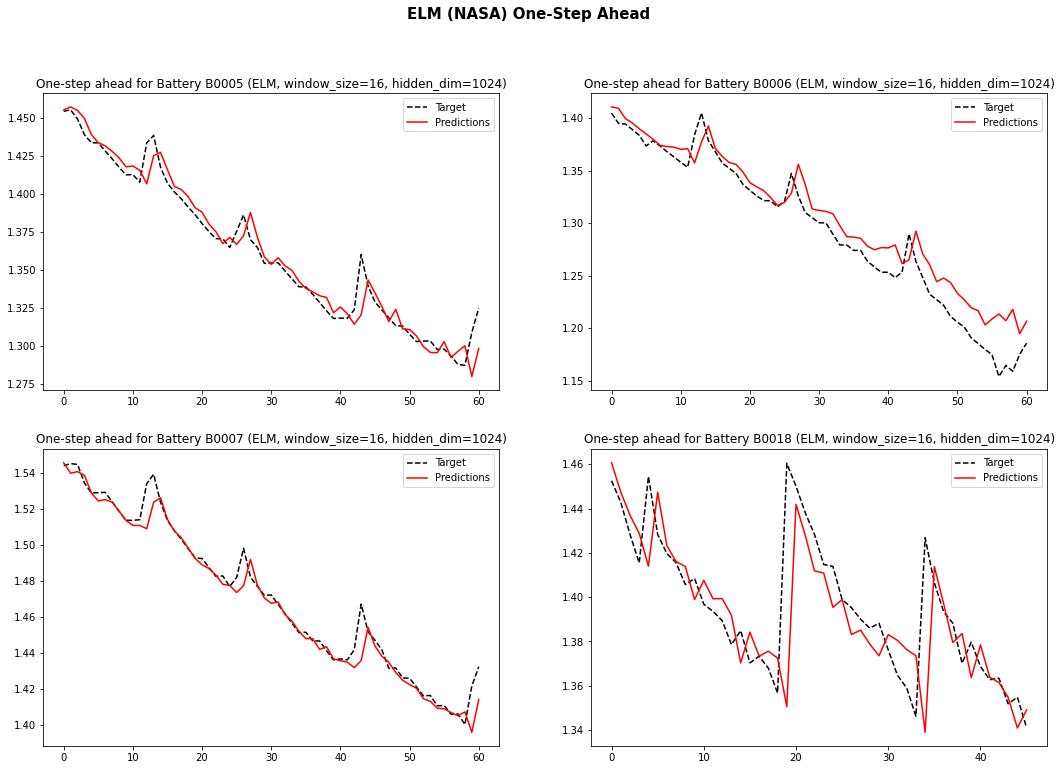

In [ ]:
plt.figure(figsize=(18,12))
plt.suptitle('ELM (NASA) One-Step Ahead',fontsize=15, weight='bold')

for leave_out, idx in zip(Battery_list, range(len(Battery_list)) ):
  model[leave_out].eval()
  acc = 0
  pred = []

  for test_tensor, label in zip(X_test[leave_out], y_test[leave_out]):
    preds = model[leave_out](test_tensor)
    pred.append(preds)

  pred = torch.cat(pred)

  # Printing Accuracy, MAE, and RMSE metrics
  acc = accuracy(y_test[leave_out].reshape(-1), pred) * 100
  mae = mean_absolute_error(y_test[leave_out].reshape(-1).cpu(),pred.cpu())
  rmse = mean_squared_error(y_test[leave_out].reshape(-1).cpu(),pred.cpu())
  print(f"Performance on Test Data {leave_out}\nAccuracy: {acc:.5f}%\tMAE: {mae:.5f}\tRMSE: {rmse:.5f}")

  # RUL Error
  idx_test = (y_test[leave_out].reshape(-1) < Rated_Capacity[leave_out]*threshold).nonzero(as_tuple=True)
  rul_test = idx_test[0][0]
  idx_pred = (pred < Rated_Capacity[leave_out]*threshold).nonzero(as_tuple=True)
  rul_pred = idx_pred[0][0]
  print(f"RUL True: {rul_test}\t\tRUL Pred: {rul_pred}\tRUL Error: {rul_test - rul_pred}\n{'-'*64}")

  # Plotting
  plt.subplot(2,2,idx+1)
  plt.plot(y_test[leave_out].cpu(),'k--',label="Target")
  plt.plot(pred.cpu(),'r-',label="Predictions")
  plt.title(f"Predictions for Battery {leave_out} (ELM, window_size={window_size}, hidden_dim={hidden_dim})")
  plt.legend()

### Iterative Multi-Step Ahead Prediction
Test using iterative prediction (using predicted output to predict future points)

In [ ]:
def plot_predictions(train_cap, train_cyc, label_cap, label_cyc, predictions, title):
  plt.title(title)
  plt.plot(train_cyc, train_cap, 'k-', label='Training data')
  plt.plot(label_cyc, label_cap, 'k:', label='Target')
  plt.plot(label_cyc, predictions, 'b-', label='Predicted')
  plt.legend()
  plt.xlabel('Number of Discharge Cycles')
  plt.ylabel('Capacity (in Ah)')

Performance for Test Data B0005:
Accuracy: 97.08159% 	MAE: 0.0393 	RMSE: 0.0434
RUL True: 17		RUL Pred: 33	RUL Error: -16
----------------------------------------------------------------
Performance for Test Data B0006:
Accuracy: 95.04922% 	MAE: 0.0618 	RMSE: 0.0753
RUL True: 9		RUL Pred: 15	RUL Error: -6
----------------------------------------------------------------
Performance for Test Data B0007:
Accuracy: 97.66577% 	MAE: 0.0341 	RMSE: 0.0386
RUL True: 22		RUL Pred: 14	RUL Error: 8
----------------------------------------------------------------
Performance for Test Data B0018:
Accuracy: 98.46640% 	MAE: 0.0216 	RMSE: 0.0265
RUL True: 15		RUL Pred: 20	RUL Error: -5
----------------------------------------------------------------


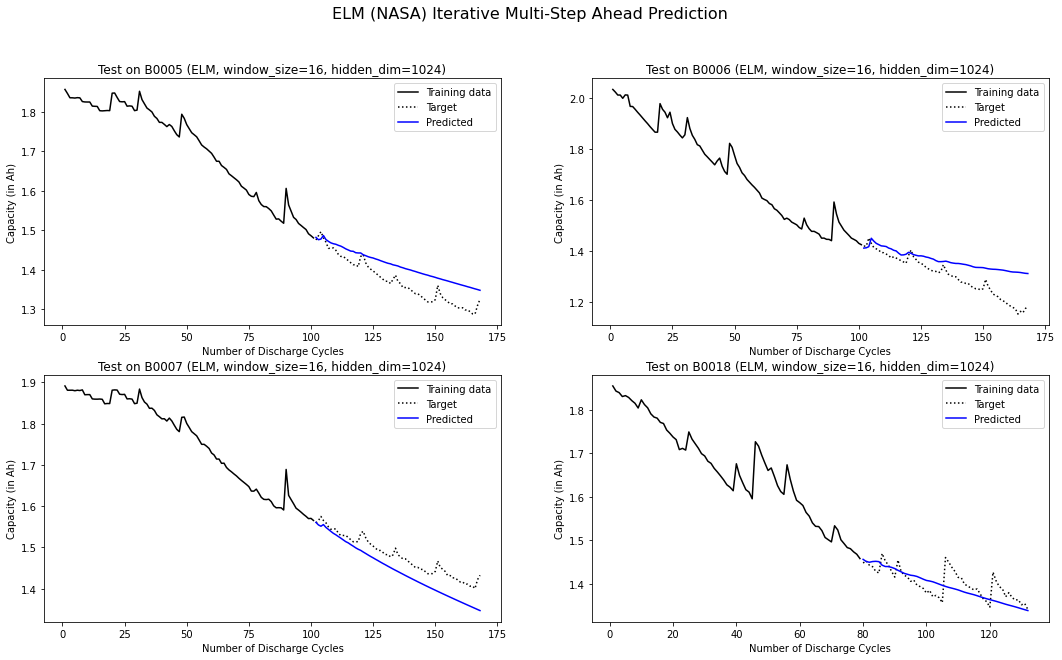

In [ ]:
plt.figure(figsize=(18,10))
plt.suptitle(f'ELM (NASA) Iterative Multi-Step Ahead Prediction', fontsize=16, weight='bold')

for leave_out, idx in zip(Battery_list, range(len(Battery_list)) ):
  predictions = {}
  for item, i in zip([leave_out], range(len(leave_out))):
    # access dictionary contents
    eval_cap, eval_cyc = test_sequence[leave_out][item]
    test_cap, test_cyc = test_labels[leave_out][item]

    # convert lists to tensors
    eval_cap, eval_cyc = eval_cap, eval_cyc
    test_cap, test_cyc = np.array(test_cap), np.array(test_cyc)

    # create point list which contains predictions
    preds = []
    # sequence which contains prediction inputs (last window_size entries of array)
    seq = eval_cap[-window_size:]

    for j in range(len(test_cap)):
      pred = model[leave_out](torch.tensor(seq, dtype=torch.float32, device=device))
      seq = seq[1:]
      seq.append(np.float64(pred))
      preds.append(np.float64(pred))

    # copy preds to dictionary
    preds = np.array(preds)
    predictions[item] = preds

    # Plots
    plt.subplot(2, 2, idx+1)
    plot_predictions(train_cap = eval_cap,
                    train_cyc = eval_cyc,
                    label_cap = test_cap,
                    label_cyc = test_cyc,
                    predictions = preds,
                    title = f"Test on {leave_out} (ELM, window_size={window_size}, hidden_dim={hidden_dim})")
    
    # Print accuracy, MAE, RMSE
    error = np.abs(preds - test_cap)/test_cap
    acc = np.ones_like(error)- error
    acc = np.sum(acc)/len(test_cap) * 100
    mae = mean_absolute_error(test_cap,preds)
    rmse = sqrt(mean_squared_error(test_cap,preds))
    print(f"Performance for Test Data {item}:\nAccuracy: {acc:.5f}% \tMAE: {mae:.4f} \tRMSE: {rmse:.4f}")

    # RUL Error
    idx_test = (torch.tensor(test_cap) < Rated_Capacity[leave_out]*threshold).nonzero(as_tuple=True)
    rul_test = idx_test[0][0]
    idx_pred = (torch.tensor(preds) < Rated_Capacity[leave_out]*threshold).nonzero(as_tuple=True)
    rul_pred = idx_pred[0][0]
    print(f"RUL True: {rul_test}\t\tRUL Pred: {rul_pred}\tRUL Error: {rul_test - rul_pred}\n{'-'*64}")

### Old training/inference scheme (Train using all datasets, up to 40% each)

In [ ]:
sequences = {}
window_size = 4
end = 1

for item in Battery_list:
  Cycle, Capacity = Battery[item]
  X_cap, y_cap = split_seq(Capacity, window_size, end)
  sequences[item] = X_cap, y_cap

# Define train test split 
train_split = 0.4                           # 40% for training, 60% for test set

X_train, y_train = [], []
X_test, y_test = [], []

test_sequence = {}
test_labels = {}

for item in Battery_list:
  # Access items from sequences dictionary
  X_cap, y_cap = sequences[item]
  Cycle, Capacity = Battery[item]

  # Get number of data points
  data_points = len(X_cap)
  data_points_test = len(Capacity)

  # Compute train-test split index
  train_split_idx = round(train_split * data_points)
  test_split_idx = round(train_split * data_points_test)

  # Split the data to training and test set
  X_train.append(X_cap[:(train_split_idx)])
  y_train.append(y_cap[:(train_split_idx)])
  X_test.append(X_cap[(train_split_idx):])
  y_test.append(y_cap[(train_split_idx):])

  # Create dictionary for test
  test_sequence[item] = Capacity[:(test_split_idx)], Cycle[:(test_split_idx)]
  test_labels[item] = Capacity[(test_split_idx):], Cycle[(test_split_idx):]

# Concatenate lists
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Reshape y
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# setup seed
seed = 2
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# specify activation
activation = nn.Sigmoid()

model = ELM(input_size=window_size, hidden_size=2048,
                  output_size=1,
                  activation=activation, 
                  X_train = X_train,
                  y_train = y_train)

torch.save(model,'ELM.pt')

accuracy for B0005: 80.13038962936022% | MAE: 0.2704 | MSE: 0.1123
accuracy for B0006: 76.53396075491136% | MAE: 0.3093 | MSE: 0.1239
accuracy for B0007: 80.60044185651411% | MAE: 0.2841 | MSE: 0.1342
accuracy for B0018: 84.28177391487178% | MAE: 0.2191 | MSE: 0.0889


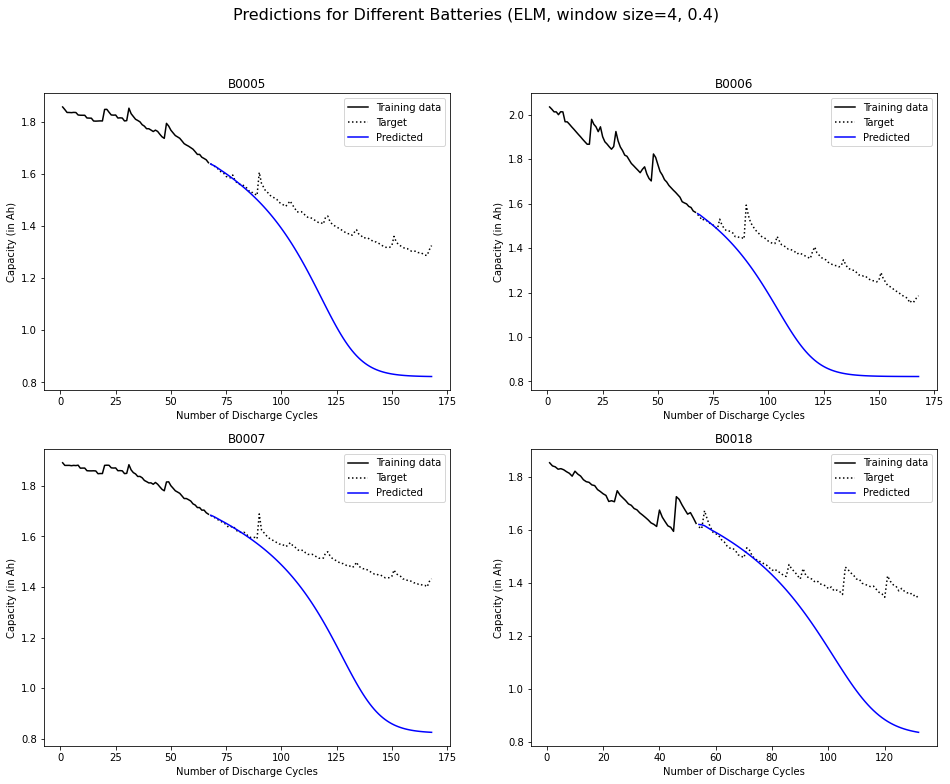

In [ ]:
predictions = {}
plt.figure(figsize=(16,12))
plt.suptitle(f'Predictions for Different Batteries (ELM, window size={window_size}, {train_split})', fontsize=16)

for item, i in zip(Battery_list, range(len(Battery_list))):
  # access dictionary contents
  eval_cap, eval_cyc = test_sequence[item]
  test_cap, test_cyc = test_labels[item]

  # convert lists to tensors
  eval_cap, eval_cyc = eval_cap, eval_cyc
  test_cap, test_cyc = np.array(test_cap), np.array(test_cyc)

  # create point list which contains predictions
  preds = []
  # sequence which contains prediction inputs (last window_size entries of array)
  seq = eval_cap[-window_size:]

  for j in range(len(test_cap)):
    pred = model(torch.tensor(seq, dtype=torch.float32))
    seq = seq[1:]
    seq.append(np.float64(pred))
    preds.append(np.float64(pred))

  # copy preds to dictionary
  preds = np.array(preds)
  predictions[item] = preds

  # plot predictions
  plt.subplot(2, 2, i+1)
  plot_predictions(train_cap = eval_cap,
                   train_cyc = eval_cyc,
                   label_cap = test_cap,
                   label_cyc = test_cyc,
                   predictions = preds,
                   title = item)
  
  # Print accuracy
  error = np.abs(preds - test_cap)/test_cap
  acc = np.ones_like(error)- error
  acc = np.sum(acc)/len(test_cap)
  mae = mean_absolute_error(test_cap,preds)
  mse = mean_squared_error(test_cap,preds)
  print(f"accuracy for {item}: {acc*100}% | MAE: {mae:.4f} | MSE: {mse:.4f}")

In [ ]:
acc = np.abs(preds - test_cap)/test_cap
acc = np.sum(acc)/len(test_cap)
print(1-acc)

0.9654626877541518


## Scratch area

In [ ]:
# Testing concatenating
np.random.seed(42)
a = np.random.rand(2,2)
b = np.random.rand(2,2)
print(f"A: {a} \nB: {b}")
c = np.empty((1,2))
print(f"empty C: {c}")
c = np.vstack((c,a))
c = np.vstack((c,b))
print(f"C: {c}")

A: [[0.37454012 0.95071431]
 [0.73199394 0.59865848]] 
B: [[0.15601864 0.15599452]
 [0.05808361 0.86617615]]
empty C: [[ 2.12656914e-138 -6.85616834e-009]]
C: [[ 2.12656914e-138 -6.85616834e-009]
 [ 3.74540119e-001  9.50714306e-001]
 [ 7.31993942e-001  5.98658484e-001]
 [ 1.56018640e-001  1.55994520e-001]
 [ 5.80836122e-002  8.66176146e-001]]


In [ ]:
raw_sequence = np.linspace(start=-200, stop=200, num=41)
raw_sequence.shape

(41,)

In [ ]:
random_seq = [1,2,3,4,5]
windowsize = len(random_seq) - 1
seq = random_seq
point_list = []

for i in range(5):
  print("==========")
  print(f"Iter {i+1}")
  pred = seq[windowsize] + 1
  print(f"{seq} -> {pred}")
  #updating the seq
  seq = seq[1:]
  seq.append(pred)
  point_list.append(pred)
  print(f"Point list: {point_list}")


Iter 1
[1, 2, 3, 4, 5] -> 6
Point list: [6]
Iter 2
[2, 3, 4, 5, 6] -> 7
Point list: [6, 7]
Iter 3
[3, 4, 5, 6, 7] -> 8
Point list: [6, 7, 8]
Iter 4
[4, 5, 6, 7, 8] -> 9
Point list: [6, 7, 8, 9]
Iter 5
[5, 6, 7, 8, 9] -> 10
Point list: [6, 7, 8, 9, 10]


In [ ]:
seq = random_seq
print(f"Seq: {seq}")
seq = seq[1:]
print(f"New Seq: {seq}")

Seq: [1, 2, 3, 4, 5]
New Seq: [2, 3, 4, 5]


In [ ]:
foo = [1,2,3,4,5,6,7,8,9]
win_size = 4
foo[-win_size:]

[6, 7, 8, 9]

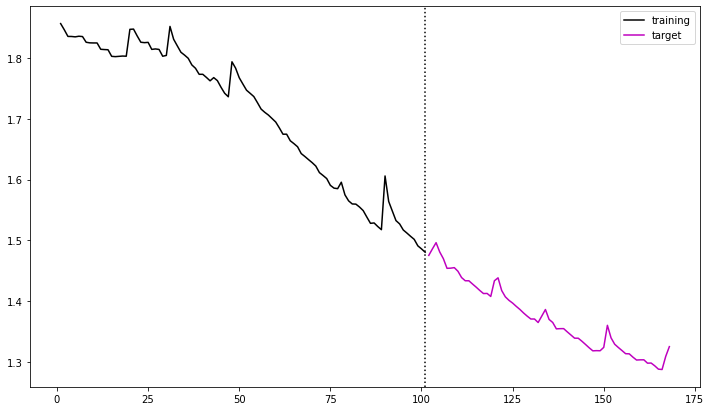

In [ ]:
cap, cyc = test_sequence['B0005']
cap_lab, cyc_lab = test_labels['B0005']
plt.figure(figsize=(12,7))
plt.plot(cyc, cap, color='k', label='training')
plt.plot(cyc_lab, cap_lab, color='m', label='target')
plt.axvline(cyc[-1],color='k',linestyle=':')
plt.legend()
plt.show()